## Loading Libraries 

In [16]:
# Basic
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

## Data Extraction 

In [17]:
train_path = "train"
test_path = "test"
image_dir = "train"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()


,filename,label
0,cat.7886.jpg,cat
1,cat.2209.jpg,cat
2,dog.10297.jpg,dog
3,cat.5677.jpg,cat
4,dog.4572.jpg,dog


## Data Exploration

 ### We visualize few images of Dogs.

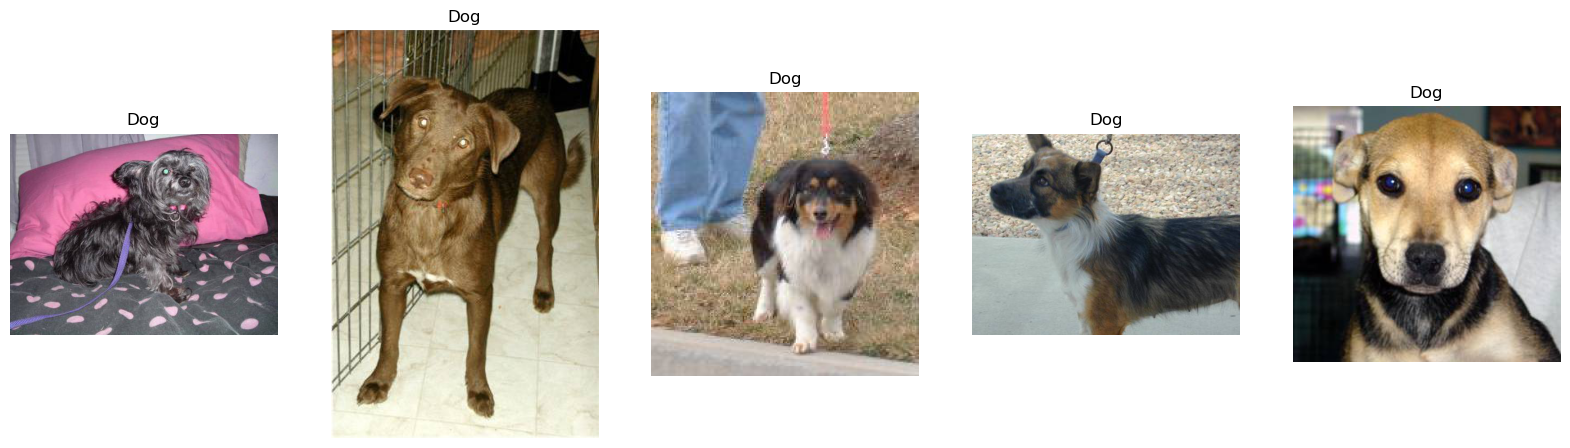

In [18]:

#Let's view more images in a grid format

plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(5):
    
    plt.subplot(1,5,i+1)    # the number of images in the grid is 10*10 (100)
    filename = 'train/' + 'dog.' + str(i) + '.jpg' # take the path
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()

### We visualize few images of Dogs.

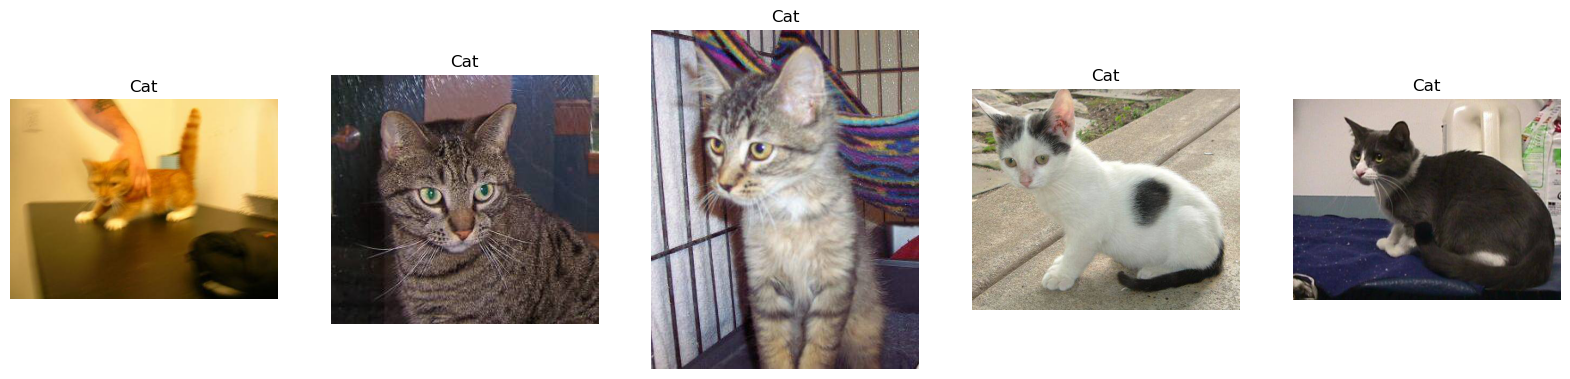

In [19]:
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(5):
    
    plt.subplot(1,5,i+1)    # the number of images in the grid is 10*10 (100)
    filename = 'train/' + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Cat',fontsize=12)
    plt.axis('off')

plt.show()


## Image preprocessing and batch generation

In [20]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a DataFrame containing the paths and labels
filenames = os.listdir(train_path)
labels = ["cat" if "cat" in x else "dog" for x in filenames]
df = pd.DataFrame({"filename": filenames, "label": labels})

# Create the DataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col="filename",
    y_col="label",
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col="filename",
    y_col="label",
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Explication :

### rescale=1./255: Normalizes pixels between 0 and 1.

### validation_split=0.2: Reserves 20% of the images for validation.
### flow_from_directory: Loads images directly from the directory and applies preprocessing.

# CNN Model Definition

This built model is a CNN designed to classify images into two categories (cat or dog) with 9 layers. It takes as input 150×150 pixel images with 3 channels (RGB) and produces a binary output (0 = cat and 1 = dog).

In [21]:
from tensorflow import keras
from tensorflow.keras import layers


model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),# Convolution with 32 filters
    layers.MaxPooling2D(2,2),#Size reduction
    
    layers.Conv2D(64, (3,3), activation='relu'), #Convolution with 64 filters
    layers.MaxPooling2D(2,2),#Size reduction
    
    layers.Conv2D(128, (3,3), activation='relu'), # Convolution with 128 filters
    layers.MaxPooling2D(2,2),#Size reduction
    
    layers.Flatten(),#Transformation into 1D vector
    layers.Dense(512, activation='relu'), #Dense layer with 512 neurons
    layers.Dense(1, activation='sigmoid')  # 1 neuron for binary classification
])


/home/student/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Explanation:

### -Conv2D(32, (3,3)): 32 filters of size 3x3 to extract features.
### -MaxPooling2D(2,2): Reduces the image size to avoid overfitting.
### -Flatten(): Transforms the output into a 1D vector.
### -Dense(512, activation='relu'): Hidden layer with 512 neurons.
### -Dense(1, activation='sigmoid'): Binary output (0: cat, 1: dog).

## We chose a batch size of 32 because:

###   Tradeoff between speed and stability

### -Small batch (< 32): More accurate, but slow (frequent gradient updates).
### -Large batch (> 128): Faster, but may converge to a suboptimal minimum.
### -Batch size 32: Balance between computational efficiency and convergence quality.

## The reason for this choice of structure

### -Conv2D with ReLU → Learns patterns in the image without negative value issues.
### -MaxPooling → Reduces the size and extracts the most important information.
### -Gradually increasing filters (32 → 64 → 128) → Allows learning more complex patterns.
### -Flatten → Dense(512) → Dense(1) → Transforms the image into a vector and makes a final decision.
### -Sigmoid output → Suitable for binary classification.

# Compiling the model

In [22]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


## Explanation:

### -Optimizer: Adam is chosen for its convergence speed and robustness.
### -Learning rate: 0.001, a standard value for a good compromise between speed and accuracy.
### -Loss function: binary_crossentropy is suitable for binary classifications.
### -Metric: accuracy is used to monitor the model's performance.

# Model training

In [23]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)


/home/student/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 453s 723ms/step - accuracy: 0.5956 - loss: 0.6917 - val_accuracy: 0.7248 - val_loss: 0.5332
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 452s 724ms/step - accuracy: 0.7409 - loss: 0.5229 - val_accuracy: 0.7764 - val_loss: 0.4777
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 391s 626ms/step - accuracy: 0.8014 - loss: 0.4347 - val_accuracy: 0.8004 - val_loss: 0.4369
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 491s 786ms/step - accuracy: 0.8469 - loss: 0.3472 - val_accuracy: 0.8206 - val_loss: 0.3961
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 387s 619ms/step - accuracy: 0.8874 - loss: 0.2595 - val_accuracy: 0.8184 - val_loss: 0.4729
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 376s 602ms/step - accuracy: 0.9397 - loss: 0.1553 - val_accuracy: 0.8222 - val_loss: 0.5138
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 411s 657ms/step - accuracy: 0.9759 - loss: 0.0708 - val_accuracy: 0.8210 - val_loss: 0.6609
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 308s 493ms/step - accuracy: 0.9885 -

## Explanation:

### -epochs=10: 10 complete iterations on the entire dataset.
### -train_generator: Training on augmented images.
### -val_generator: Performance verification on validation data.

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Prediction on validation images
y_pred = model.predict(val_generator)
y_pred = np.where(y_pred > 0.5, 1, 0) # Convert probabilities to 0 or 1

# Recover the real labels
y_true = val_generator.classes  

# Show classification report
#print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))


157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step


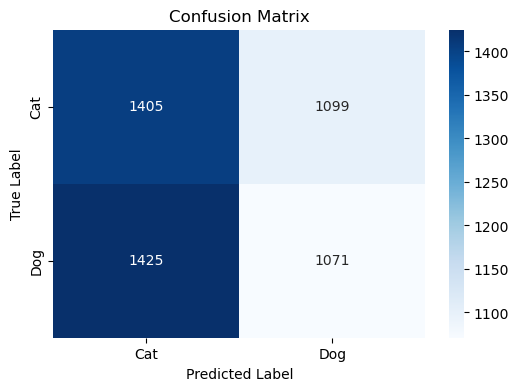

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix with seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Performance Visualization

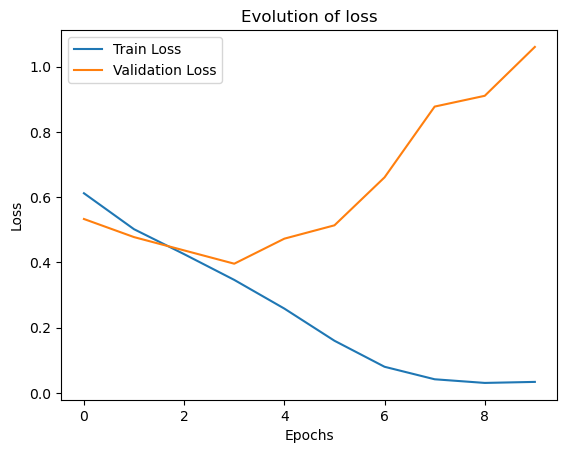

In [26]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolution of loss')
plt.show()


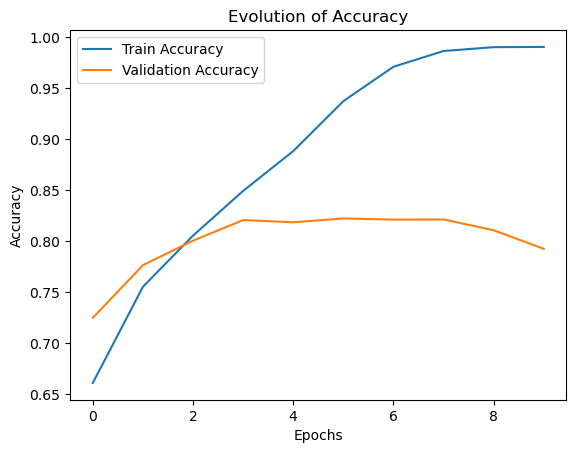

In [27]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Evolution of Accuracy')
plt.show()


# Visualize Classified images by our model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


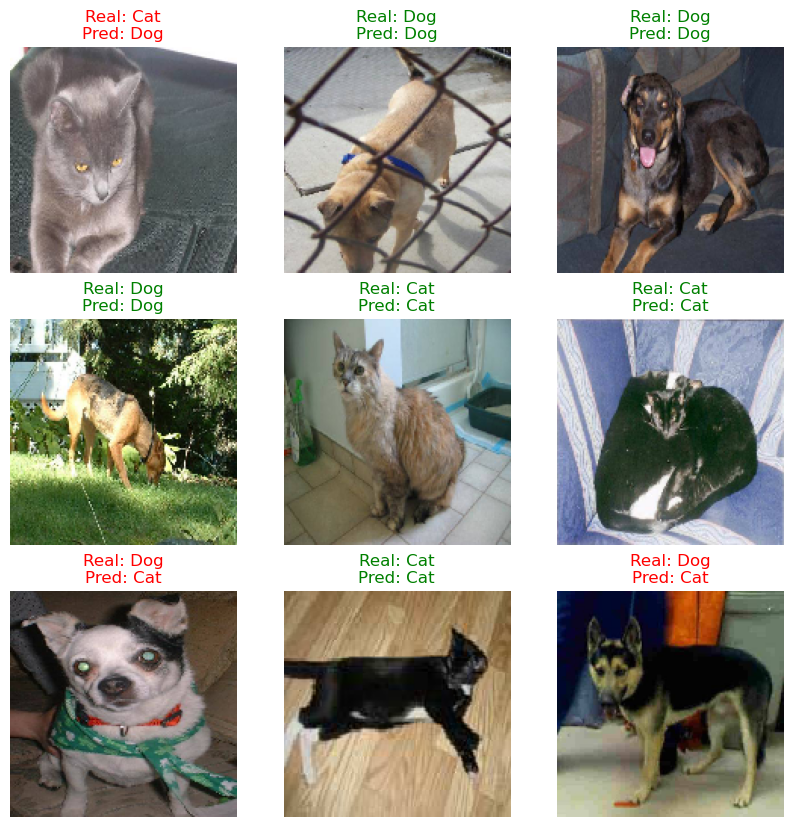

In [28]:
import random

# Randomly select images from the validation set
batch = next(val_generator)  
images, labels = batch[0], batch[1]  # Retrieve images and real classes

# Making predictions
predictions = model.predict(images)
predictions = np.where(predictions > 0.5, 1, 0)  # Convert to 0 (cat) or 1 (dog)

# Show some images with the predictions
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(images[i])
    true_label = "Cat" if labels[i] == 0 else "Dog"
    pred_label = "Cat" if predictions[i] == 0 else "Dog"
    color = "green" if true_label == pred_label else "red"
    axes[i].set_title(f"Real: {true_label}\nPred: {pred_label}", color=color)
    axes[i].axis('off')

plt.show()


## Intretation to prediction

This prediction result in red shows that the model made the prediction errors instead of cat the model predicts dog and but in general the model shows us that it performs well in fact making mostly a good classification correct which are in blue of the plot of the predictions

# Report the key ponts from this work

## Justification for hyperparameter choices:

## 1️- Optimizer: Adam
### -Combines Momentum and RMSprop, which accelerates learning and stabilizes optimization.
### -Adaptive: Automatically adjusts the learning rate for each parameter.
### -Well-suited for computer vision problems and large datasets.
### -Better convergence than simple SGD (Stochastic Gradient Descent).

## 2️- Learning Rate: 0.001
### -This is a standard value that balances speed and accuracy.
### -Too high a rate (> 0.01) risks skipping the global minimum and being unstable.
### -Too low a rate (< 0.0001) makes learning very slow.
### -Adam already adjusts rates locally, so 0.001 is a good starting point.

## 3️- Loss Function: binary_crossentropy

### -Suitable for binary classification problems (Cat vs. Dog).
### -Based on entropy, it measures the difference between predictions and true classes.
### -Favors a correct probability (close to 0 or 1) at the model output.
### -More efficient than MSE for classification.

## 4️- Metric: Accuracy

### -For a balanced binary classification (50% cats, 50% dogs), accuracy is relevant.
### -Easy to interpret: measures the percentage of correct predictions.

Finally, we will compile the model, focusing on three key elements: Optimizer, Loss, and Metrics.

Optimizer: To reduce the cost function, various methods like gradient descent and stochastic gradient descent are used. In this case, we are using the default optimizer, Adam.

Loss: Neural networks aim to minimize the loss to improve performance. We can use different loss functions like 'categorical_crossentropy' or 'binary_crossentropy'. Here, 'binary_crossentropy' is applied.

Metrics: Metrics are used to assess the performance of the model. Commonly used metrics include accuracy, but other measures can be chosen as well.

### Fit the model 

We will now proceed to train the compiled model using the training iterator (train_generator) and validate the model using the validation iterator (val_generator) during training.

It’s important to define the number of steps for both the training and validation iterators. 

This represents the number of batches per epoch, which is calculated by dividing the total number of images in the training and validation directories by the batch size (32).

The model will be trained for 10 epochs.

Après avoir analysé les images, nous observons que notre modèle fonctionne bien, 

atteignant des objectifs et les prédictions s'alignant étroitement sur les valeurs réelles, démontrant des performances fiables et cohérentes.

We successfully developed a deep learning model using a Convolutional Neural Network (CNN) to classify images of cats and dogs, achieving an impressive.

The model was tested on an independent dataset, and predictions were submitted to evaluate its performance on new data. 

This Cat vs Dog classification project highlights the effectiveness of CNNs in image recognition tasks. By accurately distinguishing between cat and dog images,

it demonstrates the power of deep learning in real-world applications. 

This project serves as an inspiration for further research into CNNs and their potential across various fields of computer vision and AI.